# This is a simple tutorial where we explore metric learning, dimensionality reduction and image retrieval using the MNIST dataset

As for the references, we used:
1. https://sanjayasubedi.com.np/nlp/nlp-with-python-nearest-neighbor-search/
2. ...

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

import matplotlib.pyplot as plt
import glob
import os
import sys

In [25]:
# We use CUDA if possible
print("CUDA is available:", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA is available: True


# Lets perform metric learning

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [27]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                'Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}'.format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )

In [28]:
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

In [29]:
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print('Computting accuracy')
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print('Test set accuracy (Precision@1) = {}'.format(accuracies['precision_at_1']))

In [30]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081))]
)

batch_size = 256

dataset1 = datasets.MNIST('.', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('.', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1

### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets='semihard'
)
accuracy_calculator = AccuracyCalculator(include=('mean_average_precision', 'r_precision', 'precision_at_1'), k=1)
### pytorch-metric-learning stuff ###

Train the model

In [31]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.1121441200375557, Number of mined triplets = 887438
Epoch 1 Iteration 20: Loss = 0.09407951682806015, Number of mined triplets = 111593
Epoch 1 Iteration 40: Loss = 0.08882083743810654, Number of mined triplets = 111560
Epoch 1 Iteration 60: Loss = 0.08552048355340958, Number of mined triplets = 63212
Epoch 1 Iteration 80: Loss = 0.08483986556529999, Number of mined triplets = 47928
Epoch 1 Iteration 100: Loss = 0.08487173914909363, Number of mined triplets = 46009
Epoch 1 Iteration 120: Loss = 0.08480457216501236, Number of mined triplets = 36229
Epoch 1 Iteration 140: Loss = 0.08620907366275787, Number of mined triplets = 33086
Epoch 1 Iteration 160: Loss = 0.08082699030637741, Number of mined triplets = 19661
Epoch 1 Iteration 180: Loss = 0.08443032950162888, Number of mined triplets = 28669
Epoch 1 Iteration 200: Loss = 0.08147731423377991, Number of mined triplets = 19136
Epoch 1 Iteration 220: Loss = 0.08337853848934174, Number of mined triplets = 22

100%|██████████| 313/313 [00:02<00:00, 122.54it/s]

If you're looking for MAP@1 instead of MAP@R, then you should use 'mean_average_precision' rather than mean_average_precision_at_r


Computting accuracy
Test set accuracy (Precision@1) = 0.9817


# Get visual representation using TSNE, PCA, UMAP

In [32]:
train_embeddings, train_labels = get_all_embeddings(dataset1, model)
print(train_embeddings.shape)
print(train_labels.shape)

100%|██████████| 1875/1875 [00:06<00:00, 282.27it/s]

torch.Size([60000, 128])
torch.Size([60000, 1])


In [33]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [34]:
def plot_embeddings(embeddings, targets, title='', xlim=None, ylim=None):
    mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

    plt.figure(figsize=(10,10))
    plt.title(title)
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

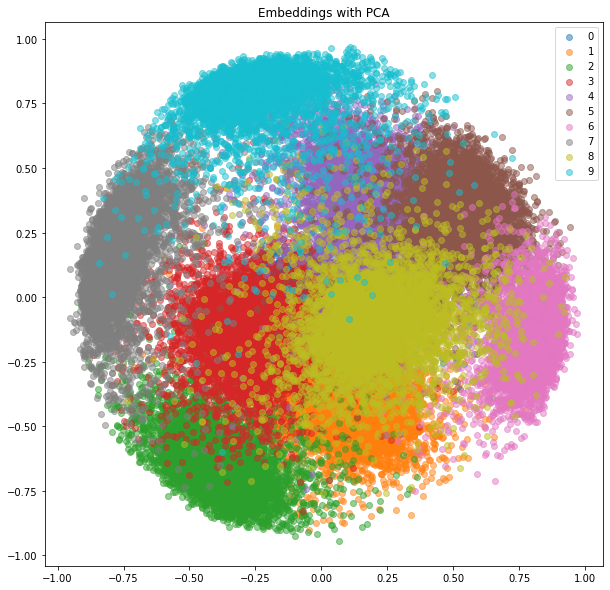

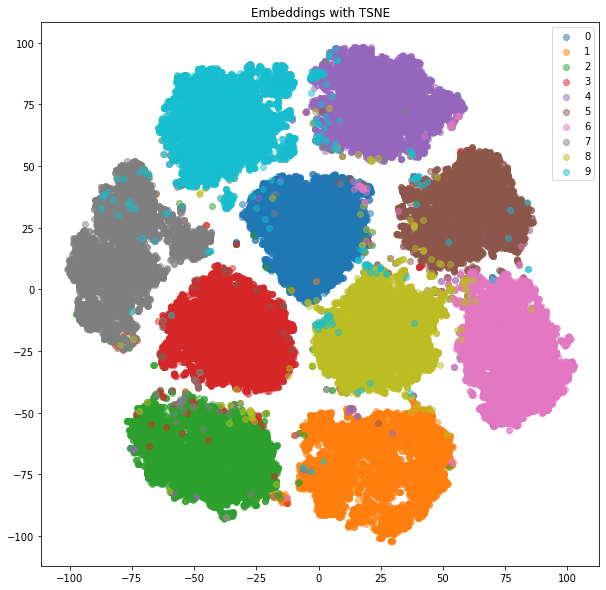

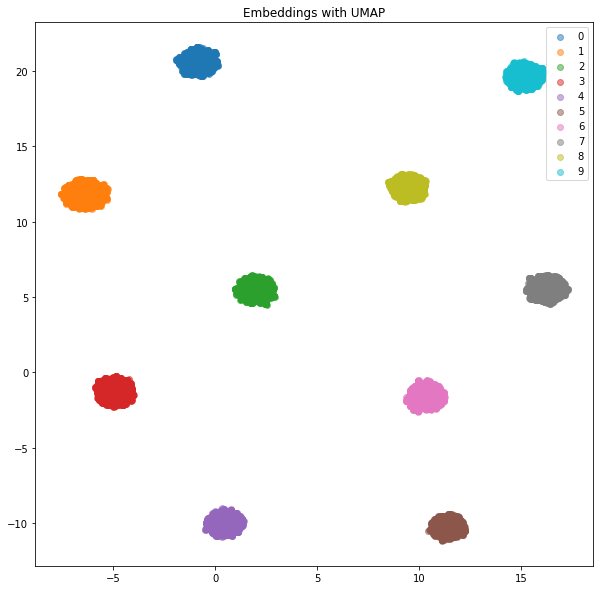

In [35]:
pca = PCA(n_components=2)
train_embeddings_pca = pca.fit_transform(train_embeddings.cpu().numpy())
plot_embeddings(train_embeddings_pca, train_labels.cpu().numpy(), title='Embeddings with PCA')

train_embeddings_tsne = TSNE(n_components=2).fit_transform(train_embeddings.cpu().numpy())
plot_embeddings(train_embeddings_tsne, train_labels.cpu().numpy(), title='Embeddings with TSNE')

train_embeddings_umap = umap.UMAP().fit_transform(train_labels.cpu().numpy())
plot_embeddings(train_embeddings_umap, train_labels.cpu().numpy(), title='Embeddings with UMAP')

# The image retrieval part

In [143]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

### Using Nearest Neighbors (NN)

In [179]:
from sklearn.neighbors import NearestNeighbors

# storing the image representations
im_indices = []
im_representations = []
embeddings_indexed = []

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model(data).cpu().numpy()
        
        for idx, (im, label) in enumerate(zip(data, labels)):
            im = im.permute(0, 1, 2).cpu().numpy()[0]
            embedding = embeddings[idx]
            im_indices.append(mnist_classes[label])
            im_representations.append(im)
            embeddings_indexed.append(embedding)
            
embeddings_indexed = np.array(embeddings_indexed)

nbrs = NearestNeighbors(n_neighbors=10, metric='cosine').fit(embeddings_indexed)
# distances, indices = nbrs.kneighbors(train_embeddings.cpu().numpy())

[[59137  6780 27364 42943 25396]]
[[0.00369012 0.00396264 0.00435179 0.00494385 0.00497937]]


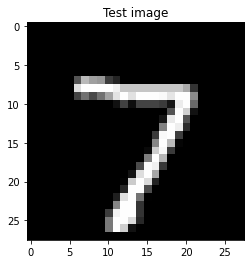

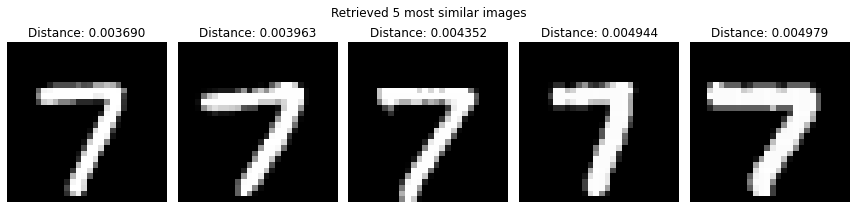

In [181]:
num_examples_to_show = 1
curr_im_idx = 0

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model(data).cpu().numpy()
        
        for idx, (im, label) in enumerate(zip(data, labels)):
            im = im.permute(0, 1, 2).cpu().numpy()[0]
            label = label.cpu().numpy()
            embedding = embeddings[idx]            
            distances, neighboor_idxs = nbrs.kneighbors([embedding], n_neighbors=5, return_distance=True)
            
            plt.figure()
            plt.title('Test image')
            plt.imshow(im, cmap='gray')
            plt.show()
            
            
            plt.figure(figsize=(12,3))
            plt.suptitle('Retrieved 5 most similar images')
            
            for i in range(5):
                plt.subplot(1, 5, i+1)
                plt.title('Distance: %f' %(distances[0][i]))
                plt.axis('off')
                plt.imshow(im_representations[neighboor_idxs[0][i]], cmap='gray')
            
            plt.tight_layout()
            plt.show()
            
            curr_im_idx += 1
            
            if curr_im_idx >= num_examples_to_show:
                break
        if curr_im_idx >= num_examples_to_show:
                break

### Using K-Nearest Neighboors KNN

In [198]:
from sklearn.neighbors import KNeighborsClassifier


# storing the image representations
im_indices = []
im_representations = []
embeddings_indexed = []
labels_indexed = []

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model(data).cpu().numpy()
        
        for idx, (im, label) in enumerate(zip(data, labels)):
            im = im.permute(0, 1, 2).cpu().numpy()[0]
            label = label.cpu().numpy()
            embedding = embeddings[idx]
            im_indices.append(mnist_classes[label])
            im_representations.append(im)
            embeddings_indexed.append(embedding)
            labels_indexed.append(label)
            
embeddings_indexed = np.array(embeddings_indexed)
labels_indexed = np.array(labels_indexed)

knn = KNeighborsClassifier(n_neighbors=5).fit(embeddings_indexed, labels_indexed)

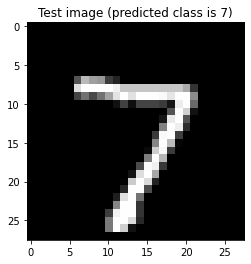

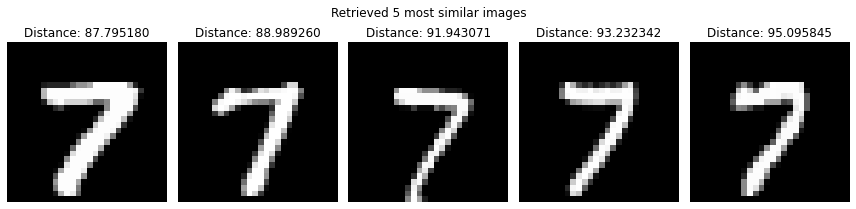

In [204]:
num_examples_to_show = 1
curr_im_idx = 0

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model(data).cpu().numpy()
        
        for idx, (im, label) in enumerate(zip(data, labels)):
            im = im.permute(0, 1, 2).cpu().numpy()[0]
            label = label.cpu().numpy()
            embedding = embeddings[idx]           
            
            distances, neighboor_idxs = knn.kneighbors([embedding], n_neighbors=5, return_distance=True)
            predicted_class = knn.predict([embedding])[0]
            
            plt.figure()
            plt.title(f'Test image (predicted class is {mnist_classes[predicted_class]})')
            plt.imshow(im, cmap='gray')
            plt.show()
            
            plt.figure(figsize=(12,3))
            plt.suptitle('Retrieved 5 most similar images')
            
            for i in range(5):
                plt.subplot(1, 5, i+1)
                plt.title('Distance: %f' %(distances[0][i]))
                plt.axis('off')
                plt.imshow(im_representations[neighboor_idxs[0][i]], cmap='gray')
            
            plt.tight_layout()
            plt.show()
            
            curr_im_idx += 1
            
            if curr_im_idx >= num_examples_to_show:
                break
        if curr_im_idx >= num_examples_to_show:
                break

### Using FAISS

In [184]:
import faiss

d = train_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(d) # build the index using dimensionality d

# storing the image representations
im_indices = []
im_representations = []

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model(data).cpu().numpy()
        
        for idx, (im, label) in enumerate(zip(data, labels)):
            im = im.permute(0, 1, 2).cpu().numpy()[0]
            label = label.cpu().numpy()
            embedding = embeddings[idx]
            
            faiss_index.add(np.array([embedding]))
            im_indices.append(mnist_classes[label])
            im_representations.append(im)

Retrieved image class (in case you want to retrieve the most similar): 7


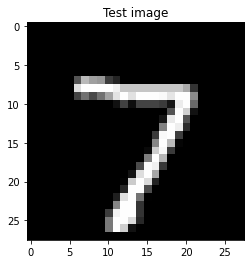

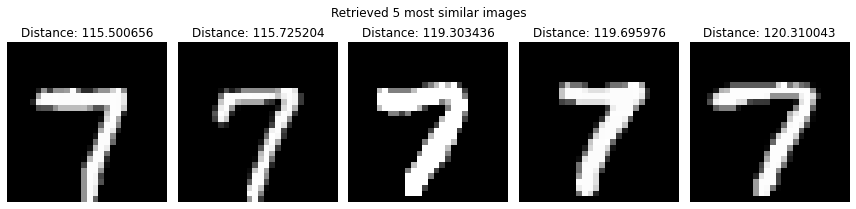

In [187]:
num_examples_to_show = 1
curr_im_idx = 0

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        embeddings = model(data).cpu().numpy()
        
        for idx, (im, label) in enumerate(zip(data, labels)):
            im = im.permute(0, 1, 2).cpu().numpy()[0]
            label = label.cpu().numpy()
            embedding = embeddings[idx]
            distances, I = faiss_index.search(np.array([embedding]), 5)
            
            # Faiss distances are returned squared
            # https://stackoverflow.com/questions/72548651/faiss-how-to-get-euclidean-distance-between-the-vectors
            distances = np.sqrt(distances)
            print("Retrieved image class (in case you want to retrieve the most similar): {}".format(im_indices[I[0][0]]))
            
            plt.figure()
            plt.title('Test image')
            plt.imshow(im, cmap='gray')
            plt.show()
            
            plt.figure(figsize=(12,3))
            plt.suptitle('Retrieved 5 most similar images')
            
            for i in range(5):
                plt.subplot(1, 5, i+1)
                plt.axis('off')
                plt.title('Distance: %f' %(distances[0][i]))
                plt.imshow(im_representations[I[0][i]], cmap='gray')
            
            plt.tight_layout()
            plt.show()
            
            curr_im_idx += 1
            
            if curr_im_idx >= num_examples_to_show:
                break
        if curr_im_idx >= num_examples_to_show:
                break